In [1]:
!pip install -q tensorflow scikit-learn matplotlib seaborn pandas joblib

import os, json, time
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib
import tensorflow as tf
from tensorflow import keras

print('Environment ready. TensorFlow version:', tf.__version__)


Environment ready. TensorFlow version: 2.19.0


In [2]:

# Upload your dataset (CSV). Use the file name shown after upload.
from google.colab import files
uploaded = files.upload()
if not uploaded:
    raise SystemExit('Please upload a CSV file to proceed.')
DATA_PATH = list(uploaded.keys())[0]
print('Uploaded file:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
df.head()


Saving supply_chain_data.csv to supply_chain_data.csv
Uploaded file: supply_chain_data.csv
Dataset shape: (100, 24)


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [3]:

# Utility functions: detect type, guess target, preprocess, train_adaptive_model
def detect_dataset_type(df):
    cols = ' '.join(df.columns.str.lower().tolist())
    if any(x in cols for x in ['shipping','carrier','distance','route','deliver']):
        return 'Logistics'
    if any(x in cols for x in ['production','manufacturing','defect','machine']):
        return 'Manufacturing'
    if any(x in cols for x in ['stock','inventory','warehouse','reorder']):
        return 'Inventory'
    if any(x in cols for x in ['sales','price','promotion','revenue']):
        return 'Retail'
    return 'General'

def guess_target(df):
    candidates = ['sales','demand','revenue','quantity','volume','orders','shippingtime','leadtime', 'amount', 'shipped', 'number of products sold', 'number of products sold'.lower()]
    for c in df.columns:
        for k in candidates:
            if k in c.lower():
                return c
    return None

def preprocess_dataframe(df, target_col=None):
    df = df.copy()
    # Separate target column before handling NaNs and other transformations
    if target_col and target_col in df.columns:
        y = df[target_col]
        X = df.drop(columns=[target_col])
    else:
        X = df
        y = None

    # Handle NaNs (forward/back fill)
    X = X.fillna(method='ffill').fillna(method='bfill')

    # date handling
    for col in list(X.columns):
        if 'date' in col.lower():
            X[col] = pd.to_datetime(X[col], errors='coerce')
            X[col + '_month'] = X[col].dt.month
            X[col + '_dow'] = X[col].dt.dayofweek
            X[col + '_quarter'] = X[col].dt.quarter
            X.drop(columns=[col], inplace=True)

    # convert bool-like to int
    for c in X.select_dtypes(include='bool').columns:
        X[c] = X[c].astype(int)

    # one-hot encode remaining object cols
    obj_cols = X.select_dtypes(include='object').columns.tolist()
    if obj_cols:
        X = pd.get_dummies(X, columns=obj_cols, drop_first=True)

    # Drop rows with any remaining NaN values after preprocessing features
    X.dropna(inplace=True)

    # Align X and y after dropping rows in X
    if y is not None:
        y = y.loc[X.index]
        if y.isnull().any():
             nan_rows = y.isnull()
             X = X[~nan_rows]
             y = y[~nan_rows]
    return X, y

def train_adaptive_model(df, target_col=None, model_type=None, epochs=30):
    # Guess target if not provided
    if target_col is None:
        target_col = guess_target(df)
        if target_col is None or target_col not in df.columns:
            df_lower_cols = [col.lower() for col in df.columns]
            if 'amount' in df_lower_cols:
                target_col = df.columns[df_lower_cols.index('amount')]
            elif 'boxes shipped' in df_lower_cols:
                target_col = df.columns[df_lower_cols.index('boxes shipped')]
            else:
                raise ValueError('Could not detect target column. Provide target_col explicitly.')

    if target_col not in df.columns:
         raise ValueError(f"Specified target column '{target_col}' not found in the dataframe.")

    X, y = preprocess_dataframe(df, target_col)

    if y is None or len(y) == 0:
         raise ValueError(f"Target column '{target_col}' resulted in no valid data after preprocessing.")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ensure numeric target
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')

    # Drop rows where target conversion resulted in NaN
    nan_y_train = y_train.isnull()
    X_train = X_train[~nan_y_train]
    y_train = y_train[~nan_y_train]

    nan_y_test = y_test.isnull()
    X_test = X_test[~nan_y_test]
    y_test = y_test[~nan_y_test]

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    detected_type = detect_dataset_type(df)
    # choose model
    if model_type is None:
        if detected_type in ['Retail','Inventory']:
            model_type = 'neural'
        else:
            model_type = 'forest'

    if model_type == 'neural':
        model = keras.Sequential([
            keras.layers.Input(shape=(X_train_s.shape[1],)),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_s, y_train, epochs=epochs, validation_split=0.15, verbose=1)
        preds = model.predict(X_test_s).flatten()
    else:
        model = RandomForestRegressor(n_estimators=200, random_state=42)
        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)

    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"Trained ({model_type}) | Type: {detected_type} | MSE: {mse:.4f} | R2: {r2:.4f}")

    os.makedirs('model', exist_ok=True)
    if model_type == 'neural':
        model.save('model/demand_model.h5')
    else:
        joblib.dump(model, 'model/demand_model.pkl')
    joblib.dump(scaler, 'model/scaler.pkl')

    # Return lots of useful objects
    return {
        'model': model,
        'scaler': scaler,
        'mse': mse,
        'r2': r2,
        'X_test': X_test,
        'y_test': y_test,
        'model_type': model_type,
        'detected_type': detected_type
    }


In [4]:

# Basic EDA and automatic training run (change epochs or pass a target_col if you want).
print('Columns found:', df.columns.tolist())
print('\nNumerical summary (first 10 rows of describe):')
display(df.describe().T.head(10))

detected = detect_dataset_type(df)
print('\nDetected dataset type:', detected)
guessed = guess_target(df)
print('Guessed target column (automatic):', guessed)

# If guess is None, set target_col manually here:
target_col = guessed  # or replace with 'HistoricalSales' or the proper column name string
print('\nUsing target column:', target_col)

result = train_adaptive_model(df, target_col=target_col, model_type=None, epochs=30)


Columns found: ['Product type', 'SKU', 'Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Customer demographics', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Defect rates', 'Transportation modes', 'Routes', 'Costs']

Numerical summary (first 10 rows of describe):


,count,mean,std,min,25%,50%,75%,max
Price,100.0,49.462461,31.168193,1.699976,19.597823,51.239831,77.198228,99.171329
Availability,100.0,48.400000,30.743317,1.000000,22.750000,43.500000,75.000000,100.000000
Number of products sold,100.0,460.990000,303.780074,8.000000,184.250000,392.500000,704.250000,996.000000
Revenue generated,100.0,5776.048187,2732.841744,1061.618523,2812.847151,6006.352023,8253.976921,9866.465458
Stock levels,100.0,47.770000,31.369372,0.000000,16.750000,47.500000,73.000000,100.000000
Lead times,100.0,15.960000,8.785801,1.000000,8.000000,17.000000,24.000000,30.000000
Order quantities,100.0,49.220000,26.784429,1.000000,26.000000,52.000000,71.250000,96.000000
Shipping times,100.0,5.750000,2.724283,1.000000,3.750000,6.000000,8.000000,10.000000
Shipping costs,100.0,5.548149,2.651376,1.013487,3.540248,5.320534,7.601695,9.929816
Lead time,100.0,17.080000,8.846251,1.000000,10.000000,18.000000,25.000000,30.000000



Detected dataset type: Logistics
Guessed target column (automatic): Number of products sold

Using target column: Number of products sold


/tmp/ipython-input-804739279.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


Trained (forest) | Type: Logistics | MSE: 160931.7355 | R2: -0.6864


Test MSE: 160931.7355 | R2: -0.6864


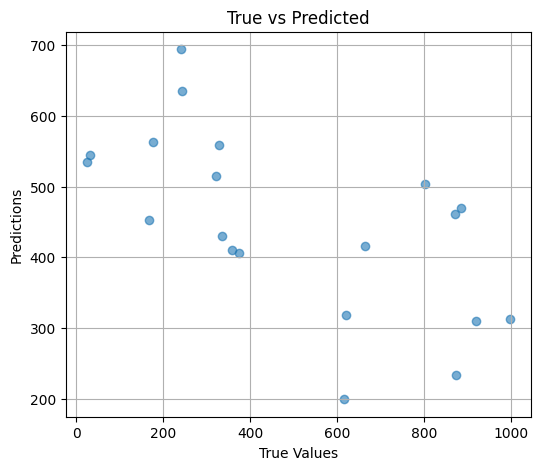

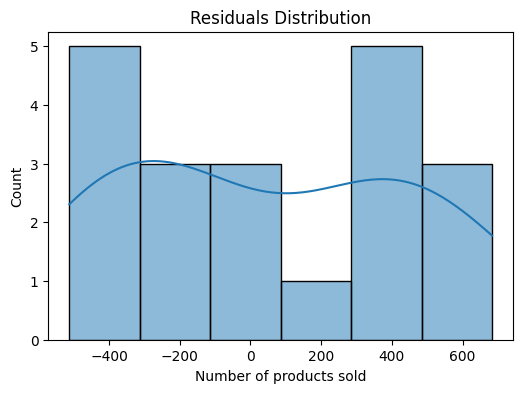

In [5]:

# Evaluation: true vs predicted and residuals
res_model = result['model']
scaler = result['scaler']
X_test = result['X_test']
y_test = result['y_test']

# Prepare test data scaled
X_test_s = scaler.transform(X_test)

if result['model_type'] == 'neural':
    preds = res_model.predict(X_test_s).flatten()
else:
    preds = res_model.predict(X_test_s)

print(f"Test MSE: {result['mse']:.4f} | R2: {result['r2']:.4f}")

# Plot true vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, preds, alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.grid(True)
plt.show()

# Residuals distribution
residuals = (y_test - preds)
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()


In [6]:

# Example: load saved model & scaler, and run a sample prediction
import numpy as np, joblib
scaler = joblib.load('model/scaler.pkl')

if result['model_type'] == 'neural':
    model_path = 'model/demand_model.h5'
    loaded = keras.models.load_model(model_path)
else:
    model_path = 'model/demand_model.pkl'
    loaded = joblib.load(model_path)

print('Loaded model from', model_path)

# Create a sample input using mean of training features (safe default)
sample = X_test.mean().to_frame().T
sample_s = scaler.transform(sample)
pred = loaded.predict(sample_s)
print('Sample input (first 10 cols):', sample.iloc[0,:10].to_dict())
print('Predicted target for sample:', float(pred.flatten()[0]) if hasattr(pred, 'flatten') else float(pred[0]))


Loaded model from model/demand_model.pkl
Sample input (first 10 cols): {'Price': 45.80891196267429, 'Availability': 42.35, 'Revenue generated': 5591.95908418646, 'Stock levels': 48.8, 'Lead times': 16.3, 'Order quantities': 56.15, 'Shipping times': 5.7, 'Shipping costs': 5.186756411302477, 'Lead time': 16.6, 'Production volumes': 575.6}
Predicted target for sample: 347.91


In [7]:

# Additional useful analyses (will only run if the relevant columns exist in your dataset)

# Low stock detection (if 'Stock levels' exists)
if any(col.lower()=='stock levels' for col in df.columns) or 'Stock levels' in df.columns:
    colname = [c for c in df.columns if c.lower()=='stock levels'][0]
    total_stock = df[colname].sum()
    print(f"Total stock: {total_stock}")
    low_stock_threshold = 10
    low_stock_items = df[df[colname] < low_stock_threshold]
    if not low_stock_items.empty:
        display(low_stock_items.head())
    else:
        print('No items under threshold.')

# Top products by sales (if column exists)
match_sales = [c for c in df.columns if 'number of products sold' in c.lower() or 'products sold' in c.lower() or 'sold'==c.lower() or 'sales' in c.lower()]
if match_sales:
    sales_col = match_sales[0]
    print('\nTop items by', sales_col)
    display(df.sort_values(by=sales_col, ascending=False).head(10))
else:
    print('\nNo obvious sales column found for top-products analysis.')


Total stock: 4777


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632
8,cosmetics,SKU8,68.717597,78,150,7517.363211,Female,5,10,15,...,Mumbai,13,769,8,11.423027,Pending,2.709863,Sea,Route B,505.557134
15,skincare,SKU15,36.989245,94,469,5442.086785,Non-binary,9,8,69,...,Bangalore,14,580,7,97.121282,Pass,2.264406,Sea,Route B,127.861800
16,skincare,SKU16,7.547172,74,280,6453.797968,Female,2,5,78,...,Bangalore,3,399,21,77.106342,Pass,1.012563,Air,Route A,865.525780



Top items by Number of products sold


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
10,skincare,SKU10,15.707796,11,996,2330.965802,Non-binary,51,13,80,...,Kolkata,18,830,5,96.527353,Pass,1.727314,Road,Route B,806.103178
94,cosmetics,SKU94,3.037689,97,987,7888.356547,Unknown,77,26,72,...,Delhi,12,908,14,60.387379,Pass,1.463607,Rail,Route B,846.665257
9,skincare,SKU9,64.015733,35,980,4971.145988,Unknown,14,27,83,...,Chennai,29,963,23,47.957602,Pending,3.844614,Rail,Route B,995.929461
36,skincare,SKU36,9.813003,34,963,7573.402458,Female,18,23,28,...,Delhi,26,671,19,45.531364,Fail,3.805533,Air,Route C,403.808974
37,skincare,SKU37,23.399845,5,963,2438.339930,Female,25,8,21,...,Kolkata,24,867,15,34.343277,Pending,2.610288,Sea,Route A,183.932968
11,skincare,SKU11,90.635460,95,960,6099.944116,Female,46,23,60,...,Kolkata,28,362,11,27.592363,Pending,0.021170,Air,Route A,126.723033
78,haircare,SKU78,6.306883,50,946,1292.458418,Unknown,5,4,51,...,Mumbai,25,858,21,71.126515,Pending,4.096881,Sea,Route C,323.592203
40,skincare,SKU40,80.541424,97,933,5724.959350,Female,90,20,39,...,Kolkata,18,793,1,88.179407,Pending,4.213269,Road,Route A,529.808724
44,cosmetics,SKU44,51.355791,34,919,7152.286049,Female,13,19,72,...,Delhi,7,834,18,22.554107,Fail,2.962626,Rail,Route A,610.453270
91,cosmetics,SKU91,62.111965,90,916,1935.206794,Male,98,22,85,...,Delhi,5,207,28,39.772883,Pending,0.626002,Rail,Route B,996.778315
